# Importing Packages

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


# ResNet50

In [3]:
cnn_base = ResNet50(include_top=False,
                    weights="imagenet",
                    input_shape=(256, 256, 3))
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=256, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))

cnn_base.trainable = False

In [5]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

Found 3830 images belonging to 2 classes.
Found 767 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [ ]:
X_test, y_test = next(test_generator)

In [6]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [7]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(train_generator,
                   epochs = 20,
                   callbacks = [earlyStopping, mcp_save],
                   validation_data = val_generator) 

Epoch 1/20
240/240 [==============================] - 865s 4s/step - loss: 0.9684 - accuracy: 0.6553 - precision: 0.6774 - recall: 0.9356 - auc: 0.5121 - auc_1: 0.6818 - val_loss: 0.4936 - val_accuracy: 0.8475 - val_precision: 0.8475 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8475
Epoch 2/20
240/240 [==============================] - 943s 4s/step - loss: 0.6368 - accuracy: 0.6677 - precision: 0.6677 - recall: 1.0000 - auc: 0.5223 - auc_1: 0.6918 - val_loss: 0.4787 - val_accuracy: 0.8475 - val_precision: 0.8475 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8475
Epoch 3/20
240/240 [==============================] - 933s 4s/step - loss: 0.6223 - accuracy: 0.6863 - precision: 0.6863 - recall: 1.0000 - auc: 0.5196 - auc_1: 0.7022 - val_loss: 0.5038 - val_accuracy: 0.8475 - val_precision: 0.8475 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8475
Epoch 4/20
240/240 [==============================] - 1449s 6s/step - loss: 0.6349 - accuracy: 0.6699 - precision: 0.6699

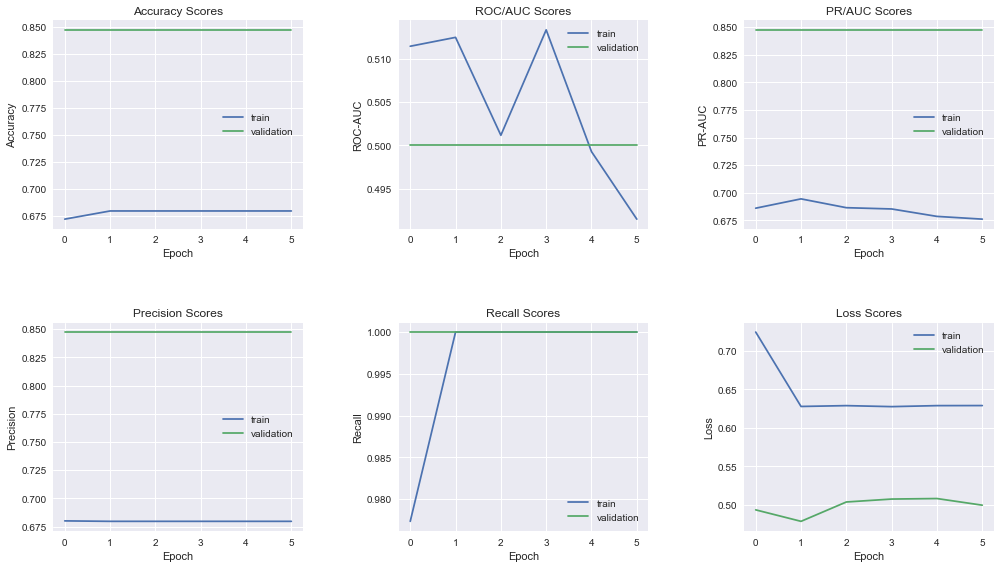

In [8]:
plt.style.use('seaborn')
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,0.724215,0.672063,0.680032,0.977334,0.511431,0.686060,0.493600,0.847458,0.847458,1.0,0.5,0.847458
1,0.627716,0.679634,0.679634,1.000000,0.512455,0.694484,0.478725,0.847458,0.847458,1.0,0.5,0.847458
2,0.628796,0.679634,0.679634,1.000000,0.501155,0.686503,0.503823,0.847458,0.847458,1.0,0.5,0.847458
3,0.627492,0.679634,0.679634,1.000000,0.513322,0.685356,0.507617,0.847458,0.847458,1.0,0.5,0.847458
4,0.628800,0.679634,0.679634,1.000000,0.499268,0.678630,0.508290,0.847458,0.847458,1.0,0.5,0.847458
5,0.628879,0.679634,0.679634,1.000000,0.491476,0.676151,0.499684,0.847458,0.847458,1.0,0.5,0.847458


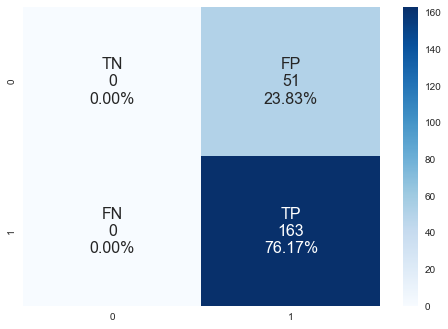

In [11]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

# AlexNet

In [23]:
model2 = AlexNet()
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(learning_rate=0.001),
               metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [22]:
filepath = '../models/Alexnet.h5'
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history2 = model2.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save],
                     validation_data = val_generator)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [9]:
plt.style.use('seaborn')
sixplot(history2, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

NameError: name 'history2' is not defined

In [22]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_2,recall_2,auc_4,auc_5,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_4,val_auc_5
0,0.456796,0.845170,0.891051,0.879754,0.896119,0.932304,0.281483,0.955752,0.959941,0.995385,0.668846,0.971292
1,0.390248,0.869974,0.911293,0.895889,0.931545,0.955177,0.263782,0.948378,0.958271,0.989231,0.672500,0.975418
2,0.346168,0.887206,0.921553,0.911640,0.941409,0.965310,0.523784,0.758112,0.972763,0.769231,0.652967,0.970857
3,0.319338,0.894517,0.924681,0.919708,0.944458,0.965154,0.364373,0.880531,0.970248,0.903077,0.653599,0.964680
4,0.284920,0.909922,0.930916,0.936996,0.957087,0.974551,0.257132,0.921829,0.965679,0.952308,0.711071,0.971905
5,0.285052,0.900522,0.925019,0.928928,0.952726,0.974015,0.208666,0.935103,0.964724,0.967692,0.775522,0.979279
6,0.268668,0.908355,0.927162,0.938917,0.955761,0.976405,0.220458,0.911504,0.968254,0.938462,0.789918,0.985753
7,0.256750,0.909922,0.932899,0.934691,0.959107,0.977785,0.341787,0.864307,0.969697,0.886154,0.659863,0.964042
8,0.236913,0.914882,0.938053,0.936612,0.964011,0.978697,0.208071,0.924779,0.965785,0.955385,0.690412,0.969817
9,0.223941,0.924021,0.943932,0.944295,0.969311,0.982755,0.195842,0.943953,0.967890,0.973846,0.713379,0.975566


In [25]:
prob = AlexNet.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5


6

In [24]:
score = AlexNet.evaluate(X_test, y_test, verbose = 0)
labels = AlexNet.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.026970352977514267
accuracy: 1.0
